In [ ]:
import random
from collections import deque
import math
from ortools.linear_solver import pywraplp

#Initialisation des variables communes
tabId = []
tabProfit = []
tabPoids = []
nbItem = 0
maxCap = 0


load C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ortools\.libs\zlib1.dll...
load C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ortools\.libs\abseil_dll.dll...
load C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ortools\.libs\utf8_validity.dll...
load C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ortools\.libs\re2.dll...
load C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ortools\.libs\libprotobuf.dll...
load C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python31

In [ ]:
#Remplissage des tableaux qui représente le graphe par lecture du fichier
def lireFichier(f):
    tabId.clear()
    tabProfit.clear()
    tabPoids.clear()

    fichier = open(f, "r")
    fichier.readline()
    fichier.readline()
    fichier.readline()
    nbItem = int((fichier.readline()).split(" ")[1])
    maxCap = int((fichier.readline()).split(" ")[1])
    fichier.readline()
    fichier.readline()
    for i in range(int(nbItem)):
        element = fichier.readline().strip().split(" ")
        tabId.append(int(element[0]))
        tabProfit.append(int(element[1]))
        tabPoids.append(int(element[2]))

    fichier.close()
    return int(nbItem), int(maxCap)


In [ ]:
### Méthode du Tabou ### 
def tabuSearch(lenTabu = 1, maxIter = 500):
    #Création de la solution initial
    xmin = solutionInitial()
    x = xmin.copy()
    fmin = sommeProfit(xmin)
    queueTabu = deque([])
    
    for i in range (0,maxIter):
        listVoisin, listChangement = listerVoisin(queueTabu, x)
        xbis, bitChanged = maximiserProfit(listVoisin, listChangement)
        if sommeProfit(xbis) < sommeProfit(x) :
            if(lenTabu != 0):
                if(len(queueTabu)==lenTabu):
                    queueTabu.popleft()
                queueTabu.append(bitChanged)
        if sommeProfit(xbis) > sommeProfit(xmin):
            xmin = xbis.copy()
            fmin = sommeProfit(xbis)
        x = xbis.copy()
    return xmin, fmin

def sommeProfit(listItem):
    sum = 0
    i=0
    for i in range(0, nbItem):
        if listItem[i] == 1 :
            sum += int(tabProfit[i])
    return sum

def isAccepted(listItem):
    sum = 0
    i=0
    for i in range(0, nbItem):
        if listItem[i] == 1 :
            sum += int(tabPoids[i])
    return (sum <= maxCap)

def listerVoisin(tabTabu, listItem):
    listVoisin = []
    listChangement = []
    for i in range(0,nbItem):
        voisin = listItem.copy()
        if voisin[i] == 0 :
            voisin[i] = 1
        else :
            voisin[i] = 0
        if not i in tabTabu and isAccepted(voisin):
            listVoisin.append(voisin)
            listChangement.append(i)
    return listVoisin, listChangement

def maximiserProfit(listVoisin, listChangement):
    max=-1
    betterVoisin = []
    bitChanged = -1
    for i in range(0, len(listVoisin)):
        if max < sommeProfit(listVoisin[i]) : 
            max = sommeProfit(listVoisin[i])
            betterVoisin = listVoisin[i]
            bitChanged = listChangement[i]
    return betterVoisin, bitChanged

def solutionInitial():
    return [0] * int(nbItem)

In [ ]:
fichier_test = "data/pi-13-1000-1000-001.kna"
nbItem, maxCap = lireFichier(fichier_test)
print(f"Capacité max: {maxCap}")
best_solution, best_profit = tabuSearch()
print(f"Meilleure solution trouvée: {best_solution}")
print(f"Profit maximal obtenu: {best_profit}")

In [17]:
print(tabuSearch(500))

([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [182]:
def recuitSimule():
    T = 100  # Température initiale
    alpha = 0.99  # Facteur de refroidissement
    Tmin = 0.1  # Température minimale
    iterMax = 1000  # Nombre d'itérations

    x = solutionInitial()  # Solution initiale
    x_best = x.copy()
    f_best = sommeProfit(x)
    
    print("Début du recuit simulé...")
    print(f"Température initiale: {T}")
    
    for iter in range(iterMax):
        if T < Tmin:
            break  # on arrete sii la température est trop basse
        
        voisin = genererVoisin(x)
        deltaE = sommeProfit(voisin) - sommeProfit(x)
        
        if deltaE > 0 or random.random() < math.exp(deltaE / T):
            x = voisin.copy()
            if sommeProfit(x) > f_best:
                x_best = x.copy()
                f_best = sommeProfit(x)
        
        T *= alpha  # Réduction de la température
        
        if iter % 100 == 0:  # pour afficher l'état toutes les 100 itérations
            print(f"Iteration {iter}, Température: {T:.2f}, Profit actuel: {sommeProfit(x)}")

    print("Recuit simulé terminé!!!!!!")
    return x_best, f_best

def genererVoisin(solution):
    voisin = solution.copy()
    i = random.randint(0, nbItem - 1)  # pour qu'onn change un élément aléatoirement
    voisin[i] = 1 - voisin[i]  
    return voisin if isAccepted(voisin) else solution  

def solutionInitial():
    return [0] * nbItem  

In [18]:
# test
fichier_test = "data/pi-13-10000-1000-001.kna"
nbItem, maxCap = lireFichier(fichier_test)
print(f"Capacité max: {maxCap}")
best_solution, best_profit = recuitSimule()
print(f"Meilleure solution trouvée: {best_solution}")
print(f"Profit maximal obtenu: {best_profit}")

Capacité max: 31234
Début du recuit simulé...
Température initiale: 100
Iteration 0, Température: 99.00, Profit actuel: 679
Iteration 100, Température: 36.24, Profit actuel: 29231
Iteration 200, Température: 13.26, Profit actuel: 29231
Iteration 300, Température: 4.86, Profit actuel: 29246
Iteration 400, Température: 1.78, Profit actuel: 29246
Iteration 500, Température: 0.65, Profit actuel: 29246
Iteration 600, Température: 0.24, Profit actuel: 29246
688
Recuit simulé terminé!!!!!!
Meilleure solution trouvée: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [256]:
fichier_test = "data/pi-15-10000-1000-001.kna"
nbItem, maxCap = lireFichier(fichier_test)

In [ ]:
%%timeit
print(recuitSimule())

Début du recuit simulé...
Température initiale: 100
Iteration 0, Température: 99.00, Profit actuel: 90
Iteration 100, Température: 36.24, Profit actuel: 49284
Iteration 200, Température: 13.26, Profit actuel: 49389
Iteration 300, Température: 4.86, Profit actuel: 49389
Iteration 400, Température: 1.78, Profit actuel: 49389
Iteration 500, Température: 0.65, Profit actuel: 49395
Iteration 600, Température: 0.24, Profit actuel: 49395
Recuit simulé terminé!!!!!!
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

: 

In [ ]:
def genetique(probaCross = 0.5, nbBest = 20, nbGen = 100, nbPop = 100):
    population = genPopulationInitial(nbPop)
    bestKnown = caculerBest(population)
    for i in range(nbGen):
        popRoulette = reproductionRoulette(population)
        nextPopulation = reproductionBest(nbBest, population)
        for j in range(nbBest + 1, nbPop):
            if random.random() < probaCross :
                nextPopulation.append(croisement(popRoulette))
            else : 
                nextPopulation.append(mutation(popRoulette))
        population = nextPopulation.copy()
        bestKnown = caculerBest(population)
    return bestKnown, sommeProfit(bestKnown)

def genPopulationInitial(nbIndividus):
    population = []
    capCible = 0.7 * maxCap

    for j in range(nbIndividus):
        solution = [0] * nbItem
        poidsTotal = 0
        indices = list(range(nbItem))
        random.shuffle(indices)

        for i in indices:
            poidsObjet = int(tabPoids[i])
            if poidsTotal + poidsObjet <= capCible:
                solution[i] = 1
                poidsTotal += poidsObjet

        population.append(solution)

    return population

def caculerBest(population):
    max=-1
    betterKnown = []
    for i in range(0, len(population)):
        if max < sommeProfit(population[i]) : 
            max = sommeProfit(population[i])
            betterKnown = population[i]
    return betterKnown

def reproductionRoulette(population):
    repro = []
    fitness = []
    for ind in population:
        fitness.append(sommeProfit(ind))
    total = sum(fitness)
    
    probaCumul = []
    cumul = 0
    for profit in fitness:
        cumul += profit / total
        probaCumul.append(cumul)

    for i in range(0, len(population)):
        rand = random.random()
        for j in range(len(probaCumul)):
            if (rand <= probaCumul[j]):
                repro.append(population[j])
                break

    return repro

def reproductionBest(nbBest,population):
    populationTrie = sorted(population, key=lambda ind: sommeProfit(ind), reverse=True)
    return populationTrie[0:nbBest]

def croisement(population):

    ind1 = population[random.randint(0, len(population) - 1)]
    ind2 = population[random.randint(0, len(population) - 1)]
    
    rand = random.randint(0, nbItem - 1)
    
    crois = ind1[:rand] + ind2[rand:]
    if (not isAccepted(crois)):
        crois = buildValidSolution(crois)

    return crois


def mutation(population):
    ind = population[random.randint(0, len(population) - 1)].copy()
    rand = random.randint(0, nbItem - 1)
    ind[rand] = 1 - ind[rand]  # Inverser le bit
    if (not isAccepted(ind)):
        ind = buildValidSolution(ind)
    return ind

def buildValidSolution(solution):
    nouvelle_solution = solution.copy()
    bit1 = []
    for j in range(nbItem) :
        if (solution[j] == 1):
            bit1.append(j)
    while not isAccepted(nouvelle_solution):
        rand = random.randint(0, len(bit1) - 1)
        i = bit1.pop(rand)
        nouvelle_solution[i] = 0

    return nouvelle_solution

In [43]:
fichier_test = "data/pi-15-1000-1000-001.kna"
nbItem, maxCap = lireFichier(fichier_test)
print(f"Capacité max: {maxCap}")
best_solution, best_profit = genetique()
print(f"Meilleure solution trouvée: {best_solution}")
print(f"Profit maximal obtenu: {best_profit}")

Capacité max: 4816
Meilleure solution trouvée: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [42]:
print(genetique())

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [3]:
def solveurLineaire():
    solver = pywraplp.Solver.CreateSolver("CBC")
    if not solver:
        print("Le solveur n'a pas pu être créé.")
        return

    n = len(tabPoids)
    x = [solver.IntVar(0, 1, f"x_{i}") for i in range(n)]

    # Contrainte de capacité
    solver.Add(solver.Sum(tabPoids[i] * x[i] for i in range(n)) <= maxCap)

    # Fonction objectif : maximiser le profit
    solver.Maximize(solver.Sum(tabProfit[i] * x[i] for i in range(n)))
    solver.SetTimeLimit(10000)
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        print("Solution trouvée :")
        for i in range(n):
            print(f"x_{i+1} = {x[i].solution_value()}")
        print(f"Profit total = {solver.Objective().Value()}")
    else:
        print("Aucune solution trouvée.")

In [4]:
fichier_test = "data/pi-12-10000-1000-001.kna"
nbItem, maxCap = lireFichier(fichier_test)

In [5]:
solveurLineaire()

Solution trouvée :
x_1 = 0.0
x_2 = 1.0
x_3 = 0.0
x_4 = 0.0
x_5 = 0.0
x_6 = 0.0
x_7 = 0.0
x_8 = 0.0
x_9 = 0.0
x_10 = 0.0
x_11 = 0.0
x_12 = 0.0
x_13 = 0.0
x_14 = 0.0
x_15 = 0.0
x_16 = 0.0
x_17 = 0.0
x_18 = 0.0
x_19 = 0.0
x_20 = 0.0
x_21 = 0.0
x_22 = 1.0
x_23 = 0.0
x_24 = 0.0
x_25 = 0.0
x_26 = 0.0
x_27 = 0.0
x_28 = 0.0
x_29 = 0.0
x_30 = 0.0
x_31 = 0.0
x_32 = 0.0
x_33 = 0.0
x_34 = 0.0
x_35 = 0.0
x_36 = 0.0
x_37 = 0.0
x_38 = 0.0
x_39 = 0.0
x_40 = 0.0
x_41 = 0.0
x_42 = 0.0
x_43 = 0.0
x_44 = 0.0
x_45 = 0.0
x_46 = 0.0
x_47 = 0.0
x_48 = 0.0
x_49 = 0.0
x_50 = 0.0
x_51 = 0.0
x_52 = 1.0
x_53 = 0.0
x_54 = 0.0
x_55 = 0.0
x_56 = 0.0
x_57 = 0.0
x_58 = 0.0
x_59 = 0.0
x_60 = 0.0
x_61 = 0.0
x_62 = 0.0
x_63 = 0.0
x_64 = 0.0
x_65 = 0.0
x_66 = 0.0
x_67 = 0.0
x_68 = 0.0
x_69 = 0.0
x_70 = 0.0
x_71 = 0.0
x_72 = 0.0
x_73 = 0.0
x_74 = 0.0
x_75 = 1.0
x_76 = 0.0
x_77 = 1.0
x_78 = 0.0
x_79 = 0.0
x_80 = 0.0
x_81 = 0.0
x_82 = 0.0
x_83 = 0.0
x_84 = 0.0
x_85 = 0.0
x_86 = 0.0
x_87 = 0.0
x_88 = 0.0
x_89 = 0.0
x_90 = 0.0


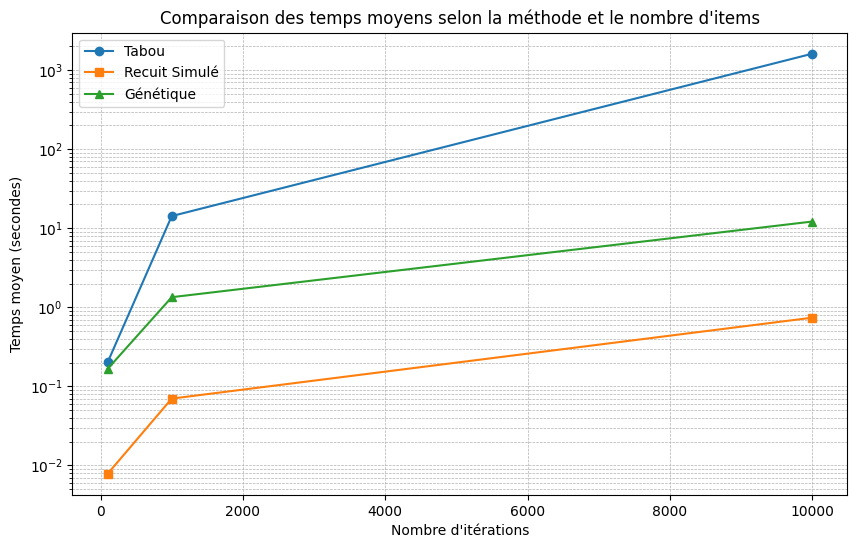

In [51]:
import matplotlib.pyplot as plt

# Itérations
iterations = [100, 1000, 10000]

# Calcul des moyennes en secondes pour chaque méthode
# Pour "Tabouuuu" : convertissons les valeurs en secondes.
# 100 itérations : 204 ms, 214 ms, 189 ms
tabou_100 = (0.204 + 0.214 + 0.189) / 3        # ~0.202 s
# 1000 itérations : 14 s, 13.6 s, 15.2 s
tabou_1000 = (14 + 13.6 + 15.2) / 3              # ~14.27 s
# 10000 itérations : 28min 2s, 28min 12s, 24min 32s
# Conversion en secondes : 28min 2s = 28*60+2 = 1682 s, etc.
tabou_10000 = (1682 + 1692 + 1472) / 3           # ~1615.33 s

tabou = [tabou_100, tabou_1000, tabou_10000]

# Pour "Recuit Simulé" :
# 100 itérations : 7.67 ms, 7.99 ms, 7.89 ms -> en secondes
recuit_100 = (0.00767 + 0.00799 + 0.00789) / 3    # ~0.00785 s
# 1000 itérations : 70.9 ms, 68.7 ms, 70.4 ms -> en secondes
recuit_1000 = (0.0709 + 0.0687 + 0.0704) / 3       # ~0.0700 s
# 10000 itérations : 736 ms, 745 ms, 737 ms -> en secondes
recuit_10000 = (0.736 + 0.745 + 0.737) / 3           # ~0.7393 s

recuit = [recuit_100, recuit_1000, recuit_10000]

# Pour "Génétique" :
# 100 itérations : 150 ms, 177 ms, 173 ms -> en secondes
genetique_100 = (0.150 + 0.177 + 0.173) / 3         # ~0.1667 s
# 1000 itérations : 1.2 s, 1.51 s, 1.32 s
genetique_1000 = (1.2 + 1.51 + 1.32) / 3            # ~1.3433 s
# 10000 itérations : 12 s, 12.4 s, 12.1 s
genetique_10000 = (12 + 12.4 + 12.1) / 3            # ~12.1667 s

genetique = [genetique_100, genetique_1000, genetique_10000]

# Création du graphe
plt.figure(figsize=(10, 6))

plt.plot(iterations, tabou, marker='o', linestyle='-', label='Tabou')
plt.plot(iterations, recuit, marker='s', linestyle='-', label='Recuit Simulé')
plt.plot(iterations, genetique, marker='^', linestyle='-', label='Génétique')

# Utilisation d'une échelle logarithmique pour l'axe y si nécessaire pour mieux visualiser les différences
plt.yscale('log')

plt.xlabel("Nombre d'itérations")
plt.ylabel("Temps moyen (secondes)")
plt.title("Comparaison des temps moyens selon la méthode et le nombre d'items")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)

plt.show()


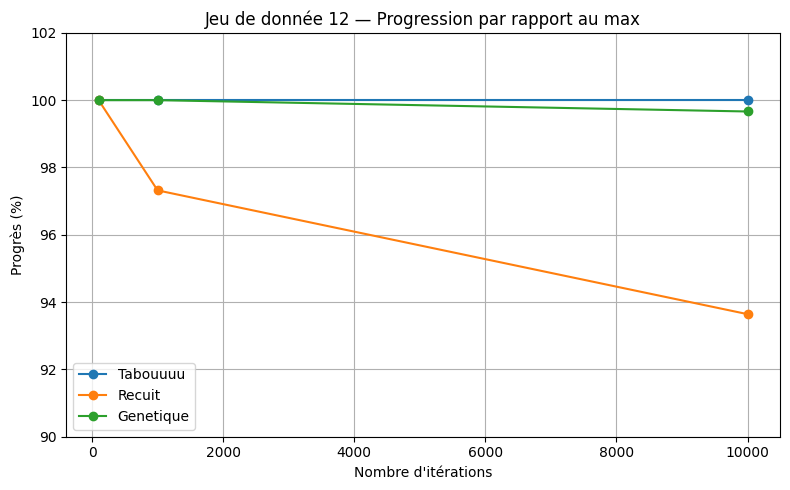

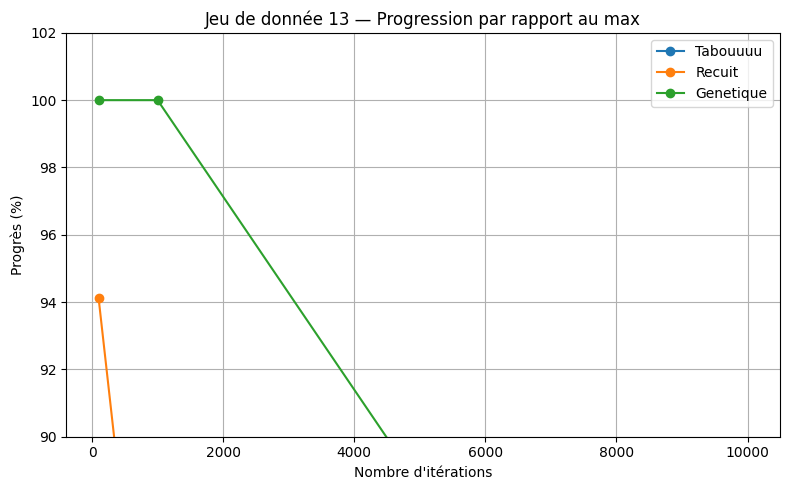

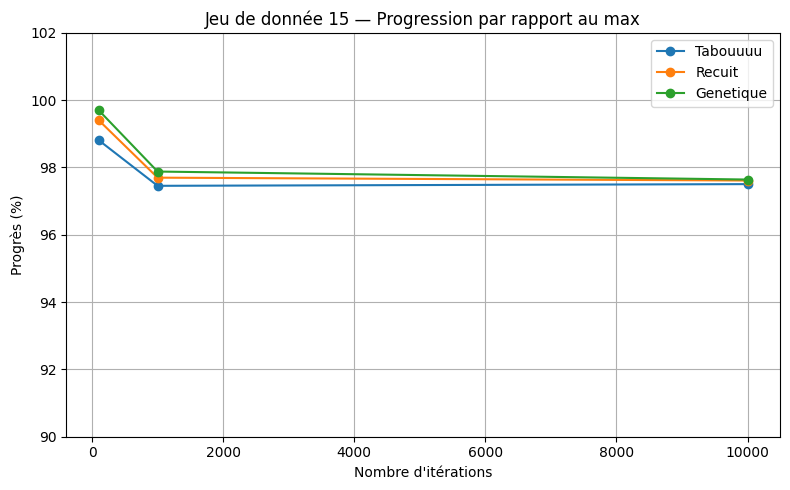

In [56]:
import matplotlib.pyplot as plt

# Iterations
iterations = [100, 1000, 10000]

# Données brutes par taille
data = {
    "12": {
        "Tabouuuu":   [970, 4514, 45105],
        "Recuit":     [970, 4393, 42237],
        "Genetique":  [970, 4514, 44953],
        "Max":        [970, 4514, 45105]
    },
    "13": {
        "Tabouuuu":   [1170, 4056, 37830],
        "Recuit":     [1872, 5109, 44226],
        "Genetique":  [1989, 6513, 47541],
        "Max":        [1989, 6513, 64077]
    },
    "15": {
        "Tabouuuu":   [999, 4824, 49359],
        "Recuit":     [1005, 4836, 49413],
        "Genetique":  [1008, 4845, 49428],
        "Max":        [1011, 4950, 50622]
    }
}

# Création des graphes
for taille in ["12", "13", "15"]:
    plt.figure(figsize=(8, 5))
    max_vals = data[taille]["Max"]

    for methode in ["Tabouuuu", "Recuit", "Genetique"]:
        values = data[taille][methode]
        pourcentages = [v / m * 100 for v, m in zip(values, max_vals)]
        plt.plot(iterations, pourcentages, marker='o', label=methode)

    plt.title(f"Jeu de donnée {taille} — Progression par rapport au max")
    plt.xlabel("Nombre d'itérations")
    plt.ylabel("Progrès (%)")
    plt.ylim(90, 102)  # zoom sur la zone intéressante
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
